Explore ISMIP6 forcing files generated on the MALI mesh. These are TF fields.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import ruptures as rpt


In [2]:
main_dir = Path.cwd().parent


In [25]:
forcing_basepath = "data/external/MALI_projects/ISMIP6_2300/forcing/data/external/MALI_projects/ISMIP6_2300/forcing/ais_mesh_4to20km_res/data/external/MALI_projects/ISMIP6_2300/forcing/ais_mesh_4to20km_res/tier1_experiments/"

In [4]:
UKESM_ssp126 = xr.open_dataset(main_dir / "data/external/MALI_projects/ISMIP6_2300/forcing/ais_mesh_4to20km_res/tier1_experiments/expAE10/AIS_4to20km_TF_UKESM1-0-LL_SSP126_2300.nc", chunks={"Time":36})
UKESM_ssp585 = xr.open_dataset(main_dir / "data/external/MALI_projects/ISMIP6_2300/forcing/ais_mesh_4to20km_res/tier1_experiments/expAE05/AIS_4to20km_r01_20220907_TF_UKESM1-0-LL_SSP585_2300.nc", chunks={"Time":36})


In [5]:
UKESM_ssp126_ts = UKESM_ssp126.mean(dim=["nCells", "nISMIP6OceanLayers"]).compute()
UKESM_ssp585_ts = UKESM_ssp585.mean(dim=["nCells", "nISMIP6OceanLayers"]).compute()

In [4]:
ssp585_globalStats = xr.open_dataset("/Users/smurugan9/research/aislens/MALI-2300/ssp585-4km/globalStats.nc")
outputflux = xr.open_dataset("/Users/smurugan9/research/aislens/MALI-2300/ssp585-4km/output_flux_all_timesteps_2250.nc")
outputstate = xr.open_dataset("/Users/smurugan9/research/aislens/MALI-2300/ssp585-4km/output_state_2250.nc")
floatbmb = xr.open_dataset("/Users/smurugan9/research/aislens/MALI-2300/ssp585-4km/ismip6-ssp585-4km-floatingBasalMassBalApplied.nc")


In [5]:
floatbmb_ts = floatbmb.mean("nCells")

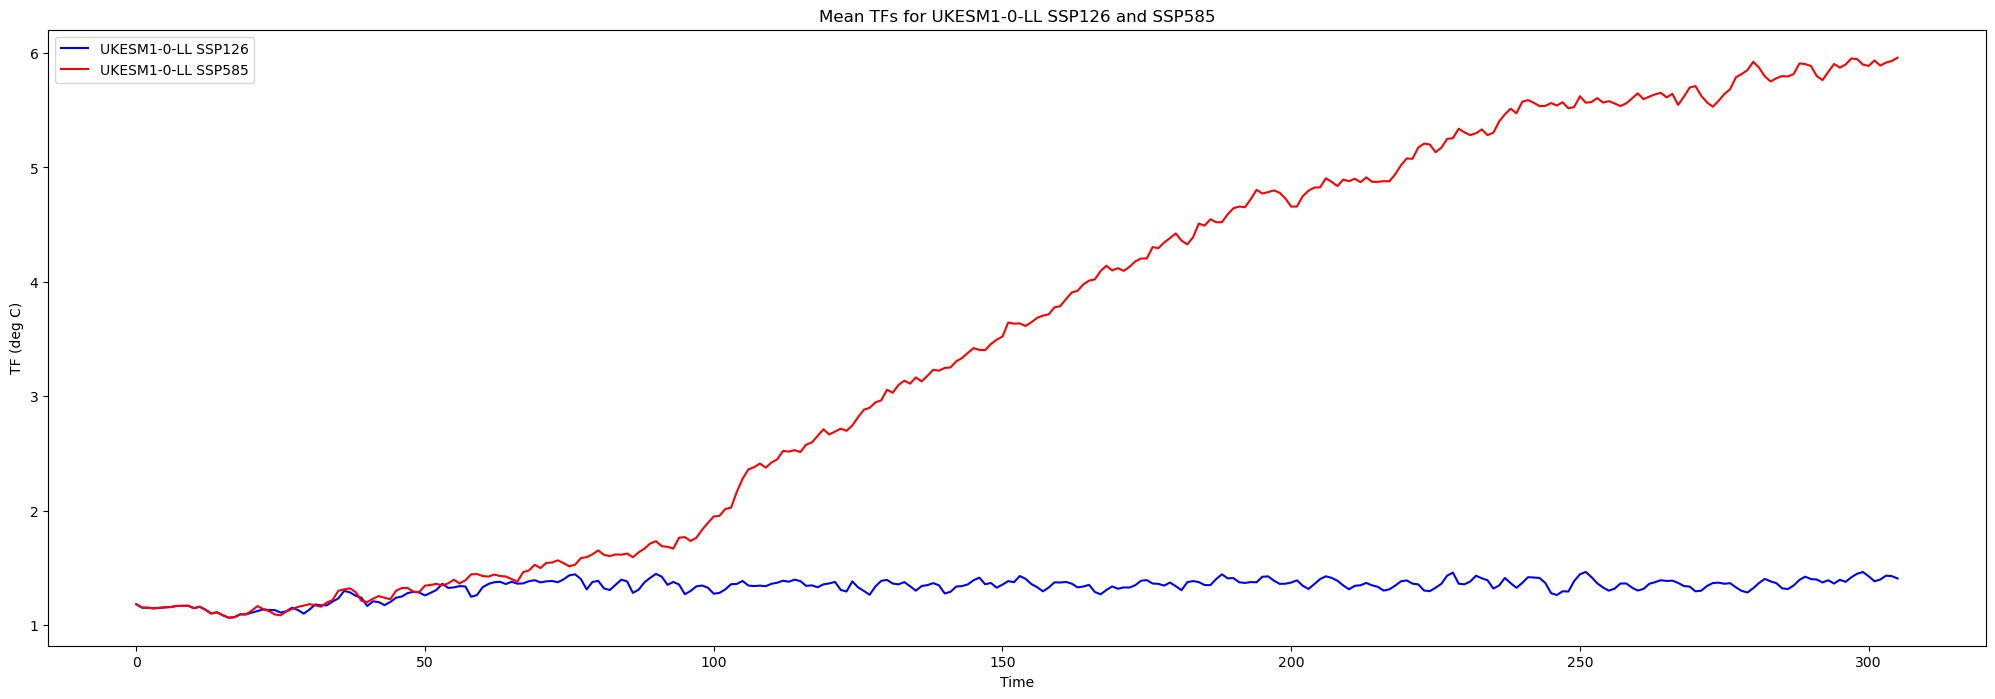

In [6]:
# Plot UKESM ssp126 and ssp585 mean TFs

fig, ax = plt.subplots(figsize=(25, 8))
UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="blue", label="UKESM1-0-LL SSP126")
UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="red", label="UKESM1-0-LL SSP585")
ax.set_title("Mean TFs for UKESM1-0-LL SSP126 and SSP585")
ax.set_xlabel("Time")
ax.set_ylabel("TF (deg C)")
ax.legend()


## Detrend (no breakpoints)

In [29]:
def detrend_dim(data, dim, deg):
    # Store the original mean
    original_mean = data.mean(dim=dim).compute()

    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg).compute()
    fit = xr.polyval(data[dim], p.polyfit_coefficients).compute()
    detrended = data - fit

    # Add back the original mean
    # detrended += original_mean

    return detrended

In [30]:
UKESM_ssp126_ts_detrended = detrend_dim(UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing, dim="Time", deg=1)
UKESM_ssp585_ts_detrended = detrend_dim(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing, dim="Time", deg=1)

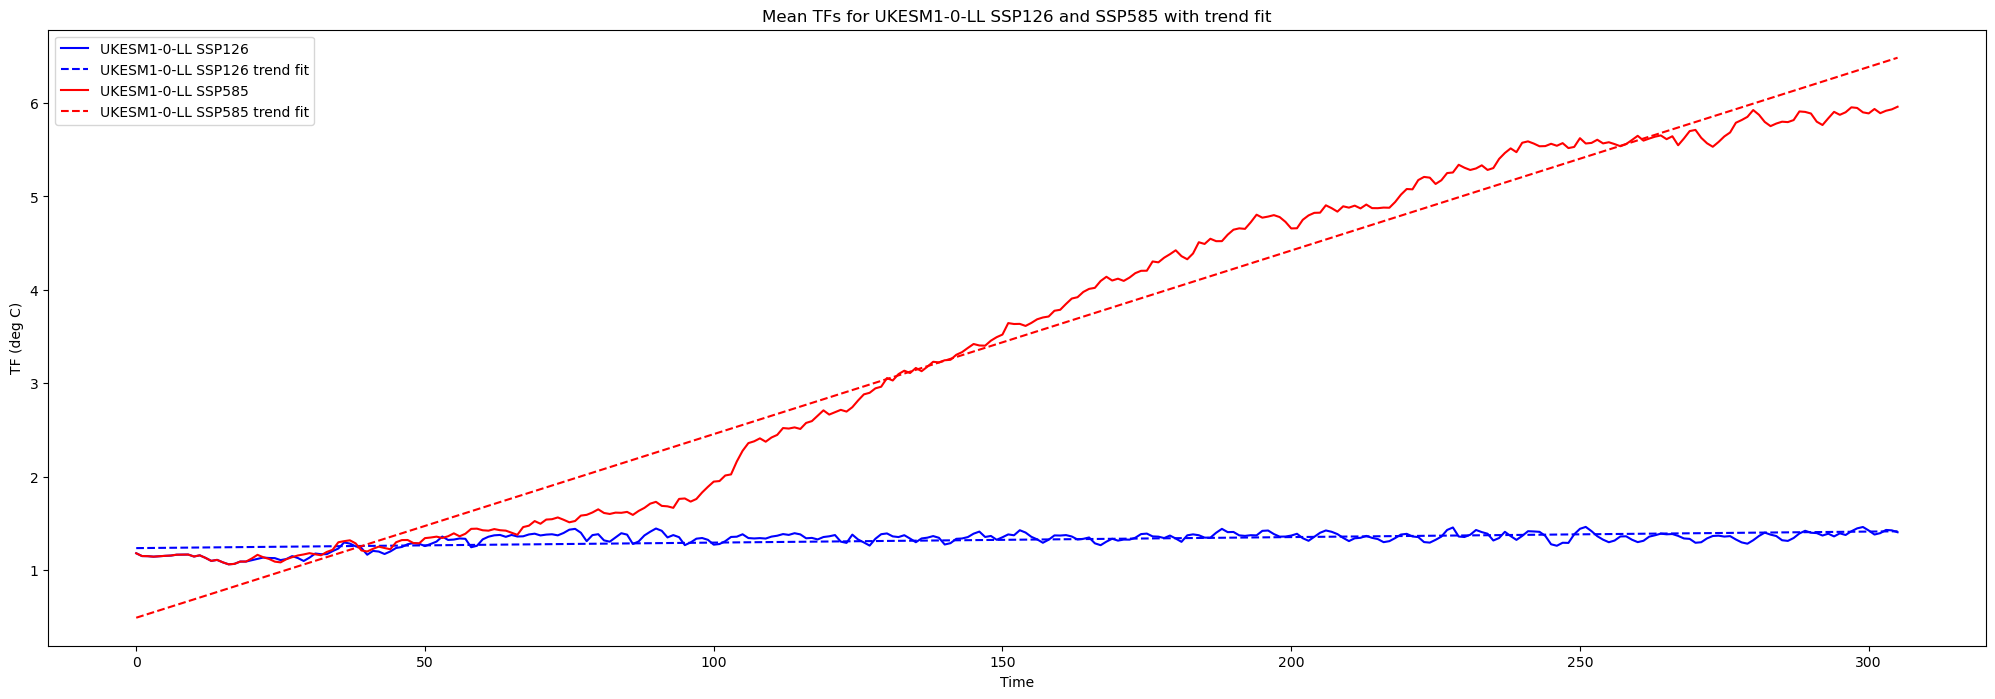

In [32]:
# Plot UKESM ssp126 and ssp585 mean TFs with trend fit
fig, ax = plt.subplots(figsize=(25, 8))
UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="blue", label="UKESM1-0-LL SSP126")
(UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp126_ts_detrended).plot(ax=ax, color="blue", linestyle="--", label="UKESM1-0-LL SSP126 trend fit")
UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="red", label="UKESM1-0-LL SSP585")
(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp585_ts_detrended).plot(ax=ax, color="red", linestyle="--", label="UKESM1-0-LL SSP585 trend fit")
ax.set_title("Mean TFs for UKESM1-0-LL SSP126 and SSP585 with trend fit")
ax.set_xlabel("Time")
ax.set_ylabel("TF (deg C)")
ax.legend()
plt.show()

## Detrend (with breakpoints)

This function below is used only for prototyping and testing, as it is designed for a 1 dimensional dataset. We will make use of a generalized xarray workflow using `xr.apply_ufunc` to define a similar detrending function to work on the entire 3 dimensional data array.

In [61]:
def detrend_with_breakpoints(data, dim, deg=1, model="l2", penalty=10):
    """
    Automatically detrend data with breakpoints based on changes in the slope.

    Parameters:
        data (xarray.DataArray): The input data to detrend.
        dim (str): The dimension along which to detrend.
        deg (int): The degree of the polynomial fit (default is 1 for linear).
        model (str): The cost model for change point detection (default is "l2").
                    1. "l1" for absolute error
                    2. "l2" for squared error
                    3. "rbf" for Gaussian error
                    4. "linear" for linear error
                    5. "normal" for normal error
        penalty (int): The penalty value for the change point detection algorithm.

    Returns:
        xarray.DataArray: The detrended data with breakpoints applied.
    """
    # Extract the data and dimension values as numpy arrays
    time = data[dim].values
    values = data.values

    # Ensure the data is 1D
    if values.ndim > 1:
        raise ValueError("Input data must be one-dimensional.")

    # Detect breakpoints using the ruptures library
    algo = rpt.Pelt(model=model).fit(values)
    breakpoints = algo.predict(pen=penalty)

    # Initialize an array to store the detrended data
    detrended_values = np.zeros_like(values)

    # Fit and detrend each segment
    start = 0
    for end in breakpoints:
        segment = slice(start, end)
        time_segment = time[segment]
        values_segment = values[segment]

        # Fit a polynomial to the segment
        coeffs = np.polyfit(time_segment, values_segment, deg)
        fit = np.polyval(coeffs, time_segment)

        # Detrend the segment
        detrended_values[segment] = values_segment - fit

        # Update the start index for the next segment
        start = end

    # Create a new xarray.DataArray with the detrended values
    detrended_data = xr.DataArray(
        detrended_values,
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs
    )

    return detrended_data

In [62]:
UKESM_ssp585_ts_detrended = detrend_with_breakpoints(
        data=UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing,
        dim="Time",
        deg=1,
        penalty=2
)

UKESM_ssp126_ts_detrended = detrend_with_breakpoints(
        data=UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing,
        dim="Time",
        deg=1,
        penalty=2
)

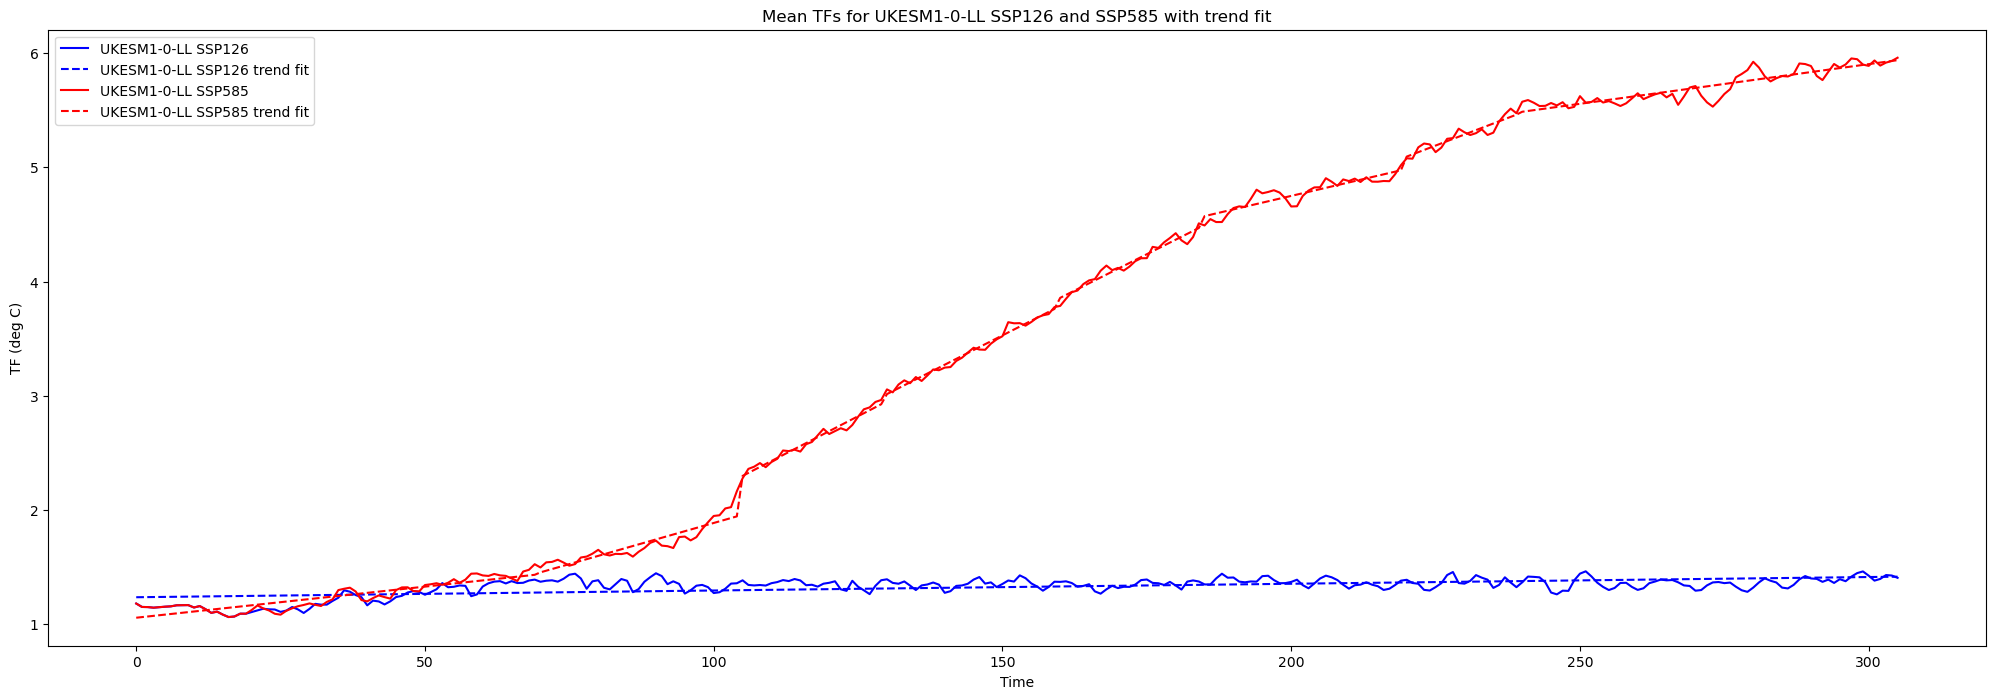

In [64]:
# Plot UKESM ssp126 and ssp585 mean TFs with break points fit
fig, ax = plt.subplots(figsize=(25, 8))
UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="blue", label="UKESM1-0-LL SSP126")
(UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp126_ts_detrended).plot(ax=ax, color="blue", linestyle="--", label="UKESM1-0-LL SSP126 trend fit")
UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="red", label="UKESM1-0-LL SSP585")
(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp585_ts_detrended).plot(ax=ax, color="red", linestyle="--", label="UKESM1-0-LL SSP585 trend fit")
ax.set_title("Mean TFs for UKESM1-0-LL SSP126 and SSP585 with trend fit")
ax.set_xlabel("Time")
ax.set_ylabel("TF (deg C)")
ax.legend()
plt.show()

## Vectorized detrend (with breakpoints using `xr.apply_ufunc`)

This is a wrapper to use `ruptures` with `xarray` and `apply_ufunc`. It uses the `ruptures` library to detect breakpoints.

Reference: [ruptures/discussions](https://github.com/deepcharles/ruptures/discussions/139)

TODO: Modify for 3D forcing datasets

In [18]:
def detect_breakpoints(arr, model="l2", penalty=10):
    """
    Detect breakpoints in a 1D array using ruptures.
    
    Parameters:
        arr (numpy.ndarray): 1D array of input data.
        model (str): The cost model for change point detection (default is "l2").
        penalty (int): The penalty value for the change point detection algorithm.

    Returns:
        list: List of breakpoints indices.
    """
    algo = rpt.Pelt(model=model).fit(arr)
    return algo.predict(pen=penalty)

def detrend_segmented(arr, time, breakpoints, deg=1):
    """
    Detrend a 1D array segment-by-segment based on breakpoints.
    
    Parameters:
        arr (numpy.ndarray): 1D array of input data.
        time (numpy.ndarray): 1D array of time values.
        breakpoints (list): List of breakpoint indices.
        deg (int): Degree of the polynomial fit (default is 1 for linear).

    Returns:
        numpy.ndarray: Detrended array.
    """
    detrended_values = np.zeros_like(arr)
    start = 0
    for end in breakpoints:
        segment = slice(start, end)
        time_segment = time[segment]
        values_segment = arr[segment]

        # Fit a polynomial to the segment
        coeffs = np.polyfit(time_segment, values_segment, deg)
        fit = np.polyval(coeffs, time_segment)

        # Detrend the segment
        detrended_values[segment] = values_segment - fit

        # Update the start index for the next segment
        start = end

    return detrended_values

def detrend_with_breakpoints_vectorized(data, dim, deg=1, model="l2", penalty=10):
    """
    Automatically detrend an xarray.DataArray with breakpoints along a specified dimension.

    Parameters:
        data (xarray.DataArray): The input data to detrend.
        dim (str): The dimension along which to detrend.
        deg (int): The degree of the polynomial fit (default is 1 for linear).
        model (str): The cost model for change point detection (default is "l2").
        penalty (int): The penalty value for the change point detection algorithm.

    Returns:
        xarray.DataArray: The detrended data with breakpoints applied.
    """
    def _process_single_slice(arr, coord_vals):
        # Detect breakpoints using ruptures
        breakpoints = detect_breakpoints(arr, model=model, penalty=penalty)
        # Detrend the data segment by segment
        return detrend_segmented(arr, coord_vals, breakpoints, deg=deg)

    detrended_data = xr.apply_ufunc(
        _process_single_slice,
        data,
        data[dim],
        input_core_dims=[[dim], [dim]],  # Specify core dimensions
        output_core_dims=[[dim]],        # Specify output dimension
        vectorize=True,                  # Enable vectorization
        #dask="parallelized",             # Allow Dask parallelization
        output_dtypes=[data.dtype]       # Ensure correct output dtype
    )

    return detrended_data

In [8]:
UKESM_ssp585_meanLayers = UKESM_ssp585.ismip6shelfMelt_3dThermalForcing.mean(dim=["nISMIP6OceanLayers"]).compute()

In [19]:
# Assuming the function detrend_with_breakpoints_vectorized is already defined

# Your DataArray
data_array = floatbmb_ts.load()

# Apply the detrending function along the "Time" dimension
detrended_data = detrend_with_breakpoints_vectorized(
    data_array,
    dim="Time",        # Specify the dimension to detrend
    deg=1,             # Degree of polynomial (e.g., 1 for linear detrending)
    model="l1",        # Cost model for ruptures
    penalty=10         # Penalty value for change point detection
)

AttributeError: 'Dataset' object has no attribute 'dtype'

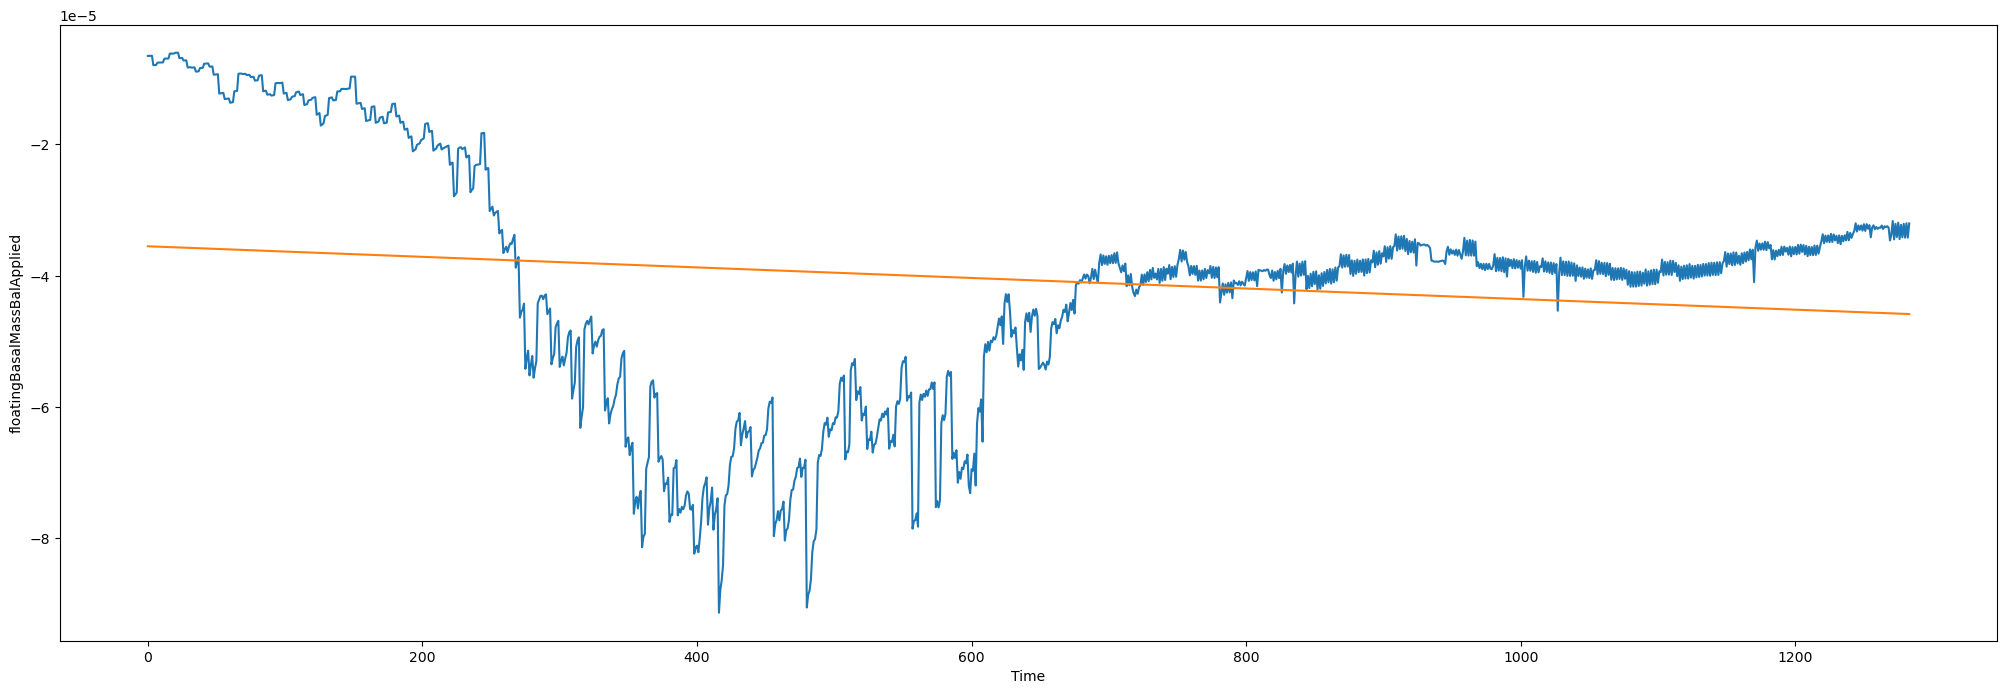

In [20]:
fig, ax = plt.subplots(figsize=(25, 8))
floatbmb_ts.floatingBasalMassBalApplied.plot()
(floatbmb_ts.floatingBasalMassBalApplied-detrended_data.floatingBasalMassBalApplied).plot()

In [10]:
# Assuming the function detrend_with_breakpoints_vectorized is already defined

# Your DataArray
data_array = UKESM_ssp585_meanLayers[0:50].load()

# Apply the detrending function along the "Time" dimension
detrended_data = detrend_with_breakpoints_vectorized(
    data_array,
    dim="Time",        # Specify the dimension to detrend
    deg=1,             # Degree of polynomial (e.g., 1 for linear detrending)
    model="l2",        # Cost model for ruptures
    penalty=10         # Penalty value for change point detection
)

In [90]:
UKESM_ssp585_detrended_ts = detrended_data.mean(dim=["nCells"]).compute()


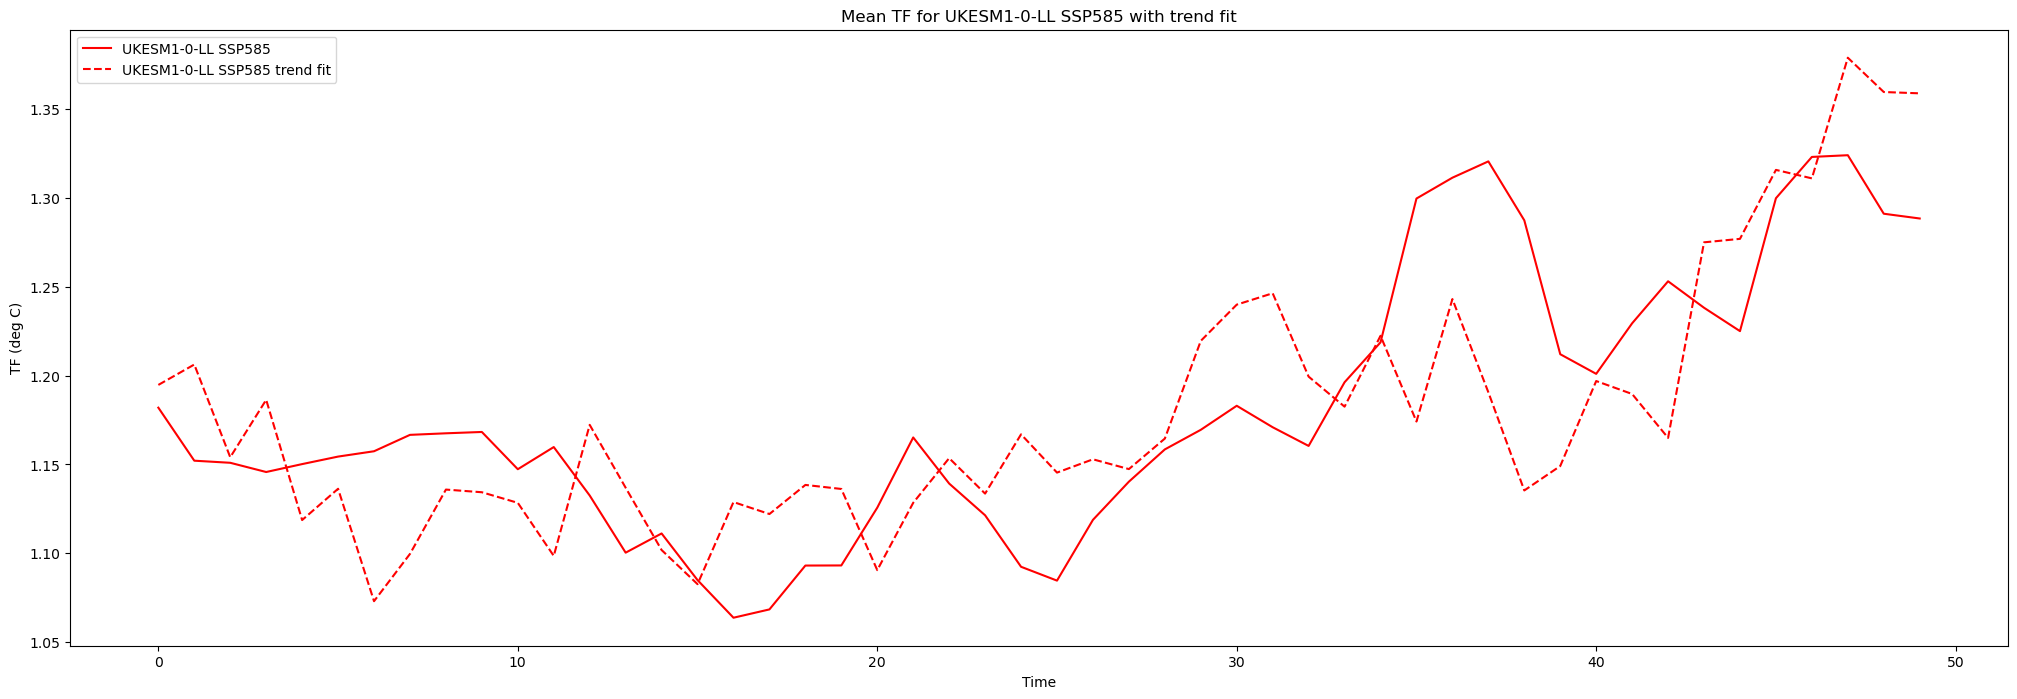

In [95]:
fig, ax = plt.subplots(figsize=(25, 8))
UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing[0:50].plot(ax=ax, color="red", label="UKESM1-0-LL SSP585")
(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing[0:50] - UKESM_ssp585_detrended_ts).plot(ax=ax, color="red", linestyle="--", label="UKESM1-0-LL SSP585 trend fit")
ax.set_title("Mean TF for UKESM1-0-LL SSP585 with trend fit")
ax.set_xlabel("Time")
ax.set_ylabel("TF (deg C)")
ax.legend()

Initial runs: 6 deterministic runs:

| Experiment       | Scenario        | Description                | Bias Correction Used |
|------------------|-----------------|----------------------------|----------------------|
| Control          | No Emissions    | Control. No thermal trend  | $\delta T$ ISMIP6    |
| UKESM SSP126     | Low Emissions   | Based on SSP126 scenario   | $\delta T$ ISMIP6    |
| UKESM SSP585     | High Emissions  | Based on SSP585 scenario   | $\delta T$ ISMIP6    |
| Control          | No Emissions    | Control. No thermal trend  | Paolo23 Sat. Obs.    |
| UKESM SSP126     | Low Emissions   | Based on SSP126 scenario   | Paolo23 Sat. Obs.    |
| UKESM SSP585     | High Emissions  | Based on SSP585 scenario   | Paolo23 Sat. Obs.    |
